In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import datetime
from sklearn import metrics
import os, sys
from PIL import Image, ImageOps
from matplotlib import image as mpimg
from sklearn.model_selection import train_test_split
import pickle

import tensorflow as tf
from tensorflow.keras.applications import DenseNet121, MobileNetV2, EfficientNetB1, EfficientNetB0
import tensorflow.keras.layers as L
from tensorflow import keras

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
pd.set_option('display.max_rows', 100)

In [3]:
#!pip3 install numpy

# Загрузка тестовых данных

In [4]:
# import zipfile
# path_to_zip_file = 'FreshFish/FreshFish_dataset.zip'
# directory_to_extract_to = 'FreshFish'
# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)

In [5]:
image_path = 'Fish/FreshFish/'
def image_dataframe(image_path):
    dirs = os.listdir( image_path )
    out_df = pd.DataFrame(columns=['img_path', 'ans'])
    for dir in dirs:
        print(dir)
        dir_folder = os.listdir(image_path + dir)
        for item in dir_folder:
            #print(item)
            if ('jpg' in item.split('.')[-1]) | ('jpeg' in item.split('.')[-1]):
                ans = dir
                #print(item)
                full_path = image_path + dir +'/' + item
                cur_df = pd.DataFrame(data = {'img_path': [full_path], 'ans': [ans]})
                out_df = pd.concat([out_df, cur_df])
    return out_df

df_train_dataset = image_dataframe(image_path)
df_train_dataset = df_train_dataset.sample(frac=1).reset_index(drop=True)
#df_train_dataset

Vimba vimba
Esox lucius
Perca fluviatilis
Carassius gibelio
Acipenseridae
Salmo trutta subsp. fario
Cyprinus carpio
Leuciscus cephalus
Gobio gobio
Rhodeus amarus
Gymnocephalus cernuus
Blicca bjoerkna
Aspius aspius
Carassius carassius
Neogobius kessleri
Lepomis gibbosus
Abramis brama
Leuciscus leuciscus
Rutilus rutilus
Tinca tinca
Neogobius melanostomus
Scardinius erythrophthalmus
Sander lucioperca
Leuciscus idus
Anguilla anguilla
Gasterosteus aculeatus
Ctenopharyngodon idella
Silurus glanis
Neogobius fluviatilis
Barbus barbus


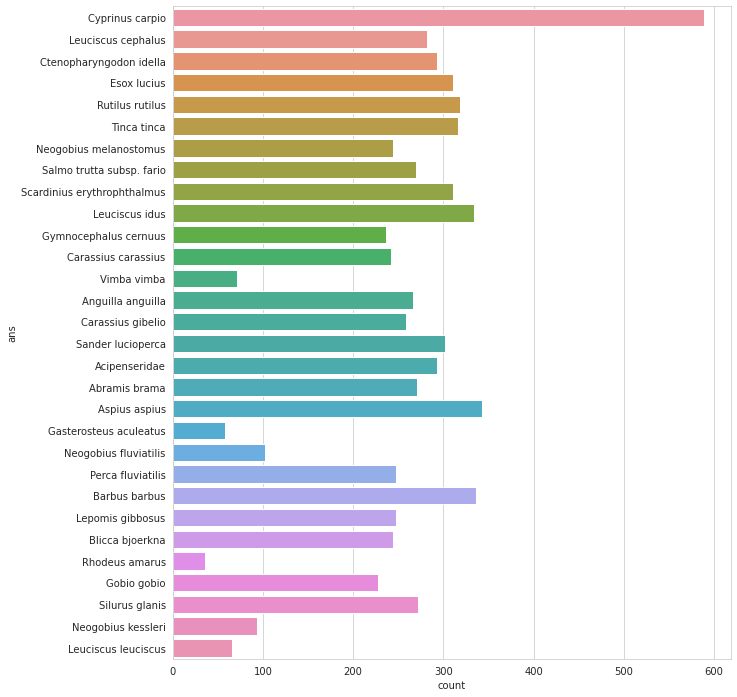

In [6]:
plt.figure(figsize=(10,12))
sns.countplot(data = df_train_dataset, y = 'ans')
plt.show()

In [7]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

2022-11-13 14:02:44.458670: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 14:02:44.459952: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-13 14:02:44.461053: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-13 14:02:44.624129: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.56GiB deviceMemoryBandwidth: 298.08GiB/s
2022-11-13 14:02:44.624207: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully ope

In [8]:
image_size = (256, 256)

def decode_image_from_array(filename, label=None, image_size=image_size):
    image = filename
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image,
                            image_size,
                            method=tf.image.ResizeMethod.BILINEAR,
                            preserve_aspect_ratio=True,
                            antialias=False,
                            name=None)

    if label is None:
        return image
    else:
        return image, label


# def decode_image_from_file(filename, label=None, image_size=image_size):
#     bits = tf.io.read_file(filename)
#     image = tf.image.decode_jpeg(bits, channels=3)
#     image = tf.cast(image, tf.float32) / 255.0
#     image = tf.image.resize(image,
#                             image_size,
#                             method=tf.image.ResizeMethod.BILINEAR,
#                             preserve_aspect_ratio=False,
#                             antialias=False,
#                             name=None)
#
#     if label is None:
#         return image
#     else:
#         return image, label

def decode_image_from_file(filename, label=None, image_size=image_size):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize_with_pad(image,
                                target_height=image_size[0],
                                target_width=image_size[1],
                                method=tf.image.ResizeMethod.BILINEAR,
                                antialias=False
                                )

    if label is None:
        return image
    else:
        return image, label

In [9]:
image_test = decode_image_from_file(df_train_dataset['img_path'].values[0])
image_test

2022-11-13 14:02:45.297131: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-13 14:02:45.298805: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.56GiB deviceMemoryBandwidth: 298.08GiB/s
2022-11-13 14:02:45.298860: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-11-13 14:02:45.298881: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-11-13 14:02:45.298891: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-11-13 14:02:45.298902: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-11-13 

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>

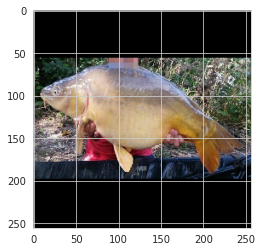

In [11]:
plt.imshow(image_test)
plt.show()

## Загрузка тренировочных данных

In [12]:
df_test_dataset = df_train_dataset[-int(df_train_dataset.shape[0]*0.3):]
df_test_dataset

,img_path,ans
5238,Fish/FreshFish/Scardinius erythrophthalmus/3e1...,Scardinius erythrophthalmus
5239,Fish/FreshFish/Acipenseridae/8d06f283-3756-422...,Acipenseridae
5240,Fish/FreshFish/Scardinius erythrophthalmus/783...,Scardinius erythrophthalmus
5241,Fish/FreshFish/Abramis brama/3ae1f4e0-3d31-4a5...,Abramis brama
5242,Fish/FreshFish/Esox lucius/16150daa-b02c-45f6-...,Esox lucius
...,...,...
7477,Fish/FreshFish/Blicca bjoerkna/123016-200mm.jpg,Blicca bjoerkna
7478,Fish/FreshFish/Blicca bjoerkna/39ed2606-1a52-4...,Blicca bjoerkna
7479,Fish/FreshFish/Carassius carassius/15584-400mm...,Carassius carassius
7480,Fish/FreshFish/Silurus glanis/9286a3f8-19d5-49...,Silurus glanis


In [13]:
# cifar_10 = keras.datasets.cifar10
# (x_train, y_train), (x_val, y_val) = cifar_10.load_data()
x_train, x_val = train_test_split(df_train_dataset[:-int(df_train_dataset.shape[0]*0.3)], test_size=0.33, random_state=42)

In [42]:
x_train.reset_index(drop=True, inplace=True)
train_dummy = pd.get_dummies(x_train, prefix=[''], prefix_sep=[''], columns=['ans'], drop_first=False)
train_dummy.head(3)

,img_path,Abramis brama,Acipenseridae,Anguilla anguilla,Aspius aspius,Barbus barbus,Blicca bjoerkna,Carassius carassius,Carassius gibelio,Ctenopharyngodon idella,...,Neogobius melanostomus,Perca fluviatilis,Rhodeus amarus,Rutilus rutilus,Salmo trutta subsp. fario,Sander lucioperca,Scardinius erythrophthalmus,Silurus glanis,Tinca tinca,Vimba vimba
0,Fish/FreshFish/Gobio gobio/38827-0mm.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Fish/FreshFish/Acipenseridae/93a1c9b8-bd7b-42a...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Fish/FreshFish/Carassius gibelio/103700-470mm.jpg,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
x_val.reset_index(drop=True, inplace=True)
val_dummy = pd.get_dummies(x_val, prefix=[''], prefix_sep=[''], columns=['ans'], drop_first=False)
val_dummy.head(3)

,img_path,Abramis brama,Acipenseridae,Anguilla anguilla,Aspius aspius,Barbus barbus,Blicca bjoerkna,Carassius carassius,Carassius gibelio,Ctenopharyngodon idella,...,Neogobius melanostomus,Perca fluviatilis,Rhodeus amarus,Rutilus rutilus,Salmo trutta subsp. fario,Sander lucioperca,Scardinius erythrophthalmus,Silurus glanis,Tinca tinca,Vimba vimba
0,Fish/FreshFish/Neogobius melanostomus/3d31358f...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,Fish/FreshFish/Sander lucioperca/9e01c2ac-0a2a...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Fish/FreshFish/Esox lucius/120322-570mm.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
df_test_dataset.reset_index(drop=True, inplace=True)
test_dummy  = pd.get_dummies(df_test_dataset, prefix=[''], prefix_sep=[''], columns=['ans'], drop_first=False)
test_dummy.head(3)

,img_path,Abramis brama,Acipenseridae,Anguilla anguilla,Aspius aspius,Barbus barbus,Blicca bjoerkna,Carassius carassius,Carassius gibelio,Ctenopharyngodon idella,...,Neogobius melanostomus,Perca fluviatilis,Rhodeus amarus,Rutilus rutilus,Salmo trutta subsp. fario,Sander lucioperca,Scardinius erythrophthalmus,Silurus glanis,Tinca tinca,Vimba vimba
0,Fish/FreshFish/Scardinius erythrophthalmus/3e1...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,Fish/FreshFish/Acipenseridae/8d06f283-3756-422...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Fish/FreshFish/Scardinius erythrophthalmus/783...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [16]:
label_name = pd.DataFrame(df_train_dataset['ans'].unique()).sort_values(by=0).reset_index(drop=True)[0].to_dict()
label_name

{0: 'Abramis brama',
 1: 'Acipenseridae',
 2: 'Anguilla anguilla',
 3: 'Aspius aspius',
 4: 'Barbus barbus',
 5: 'Blicca bjoerkna',
 6: 'Carassius carassius',
 7: 'Carassius gibelio',
 8: 'Ctenopharyngodon idella',
 9: 'Cyprinus carpio',
 10: 'Esox lucius',
 11: 'Gasterosteus aculeatus',
 12: 'Gobio gobio',
 13: 'Gymnocephalus cernuus',
 14: 'Lepomis gibbosus',
 15: 'Leuciscus cephalus',
 16: 'Leuciscus idus',
 17: 'Leuciscus leuciscus',
 18: 'Neogobius fluviatilis',
 19: 'Neogobius kessleri',
 20: 'Neogobius melanostomus',
 21: 'Perca fluviatilis',
 22: 'Rhodeus amarus',
 23: 'Rutilus rutilus',
 24: 'Salmo trutta subsp. fario',
 25: 'Sander lucioperca',
 26: 'Scardinius erythrophthalmus',
 27: 'Silurus glanis',
 28: 'Tinca tinca',
 29: 'Vimba vimba'}

In [17]:
targets = list(label_name.values())
targets

['Abramis brama',
 'Acipenseridae',
 'Anguilla anguilla',
 'Aspius aspius',
 'Barbus barbus',
 'Blicca bjoerkna',
 'Carassius carassius',
 'Carassius gibelio',
 'Ctenopharyngodon idella',
 'Cyprinus carpio',
 'Esox lucius',
 'Gasterosteus aculeatus',
 'Gobio gobio',
 'Gymnocephalus cernuus',
 'Lepomis gibbosus',
 'Leuciscus cephalus',
 'Leuciscus idus',
 'Leuciscus leuciscus',
 'Neogobius fluviatilis',
 'Neogobius kessleri',
 'Neogobius melanostomus',
 'Perca fluviatilis',
 'Rhodeus amarus',
 'Rutilus rutilus',
 'Salmo trutta subsp. fario',
 'Sander lucioperca',
 'Scardinius erythrophthalmus',
 'Silurus glanis',
 'Tinca tinca',
 'Vimba vimba']

## ML

### Run model on GPU

In [18]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

2022-11-13 14:02:45.679993: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-13 14:02:45.681871: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.56GiB deviceMemoryBandwidth: 298.08GiB/s
2022-11-13 14:02:45.681955: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-11-13 14:02:45.681983: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-11-13 14:02:45.681998: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-11-13 14:02:45.682012: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-11-13 

### Run model on CPU

In [19]:
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
#
# if tf.test.gpu_device_name():
#     print('GPU found')
# else:
#     print("No GPU found")

In [53]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_dummy['img_path'], train_dummy[targets]))
    .map(decode_image_from_file, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

val_dataset = (
    tf.data.Dataset
        .from_tensor_slices((val_dummy['img_path'], val_dummy[targets]))
        .map(decode_image_from_file, num_parallel_calls=AUTO)
        .repeat()
        .shuffle(512)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
)


# test_dataset = (
#     tf.data.Dataset
#         .from_tensor_slices((df_test_dataset['img_path']))
#         .map(decode_image_from_file, num_parallel_calls=AUTO)
#         .batch(1)
#         .prefetch(AUTO)
# )

test_dataset = (
    tf.data.Dataset
        .from_tensor_slices((test_dummy['img_path'], test_dummy[targets]))
        .map(decode_image_from_file, num_parallel_calls=AUTO)
        .batch(1)
        .prefetch(AUTO)
)
# val_dataset = test_dataset #так как все гиперпараметры уже были подобранны

# Инициализация модели

In [54]:
#model = tf.keras.models.load_model('scrap_clas__0410.h5')

In [55]:
#model.save('scrap_clas__0410.h5', save_format = 'h5')

In [56]:
!nvidia-smi

Sun Nov 13 16:47:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:8B:00.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |   5414MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
model = tf.keras.Sequential([DenseNet121(input_shape=image_size+ (3,),
                                     weights='imagenet',
                                     include_top=False),
                         L.GlobalAveragePooling2D(),
                         L.Dropout(rate=0.5),
                         tf.keras.layers.BatchNormalization(),
                         L.Dense(64,activation='relu'),
                         L.Dense(len(label_name),activation='softmax')])

model.compile(optimizer='adam',
          loss = 'categorical_crossentropy',
          metrics=['accuracy'])

In [25]:
!nvidia-smi

Sun Nov 13 14:02:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:8B:00.0 Off |                    0 |
| N/A   44C    P0    26W /  70W |   4736MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1950      
Total params: 7,109,150
Trainable params: 7,023,454
Non-trainable params: 85,696
_________________________________________

# Обучение

In [27]:
def scheduler(epoch, lr=0.0001):
      if epoch < 2:
        return 0.0001
      else:
        return lr/2

    
EPOCHS = 20
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
STEPS_PER_EPOCH = 2*x_train.shape[0] // BATCH_SIZE
#STEPS_PER_EPOCH = 200
VAL_STEPS_PER_EPOCH = x_val.shape[0] #просто смотрим на тестовый скор, гиперпараметры были подобраны ранее
#VAL_STEPS_PER_EPOCH = 200

In [28]:
STEPS_PER_EPOCH, VAL_STEPS_PER_EPOCH

(438, 1729)

In [ ]:
tb_date = datetime.datetime.now().strftime("%Y.%m.%d-%H:%M:%S")
'''logdir = './model_logs/Class_logs/logs_{}'.format(tb_date)

tbCallBack = keras.callbacks.TensorBoard(log_dir=logdir,
                                         update_freq="epoch",
                                         histogram_freq=2, 
                                         write_graph=True, 
                                         write_images=True)'''

history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    callbacks=[lr_schedule, 
                               #tbCallBack,
                               #tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
                               #tf.keras.callbacks.ModelCheckpoint(
                               #    filepath='model_save/class/class_model.{epoch:02d}-{val_accuracy:.2f}.h5'),
                              ],
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VAL_STEPS_PER_EPOCH,
                    validation_data=val_dataset #просто смотрим на тестовый скор, гиперпараметры были подобраны ранее
                    )

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.


2022-11-13 14:02:54.498080: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-13 14:02:54.540749: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1995310000 Hz
2022-11-13 14:02:56.755399: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-11-13 14:02:57.326030: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-11-13 14:02:57.338505: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


438/438 [==============================] - 201s 431ms/step - loss: 2.9431 - accuracy: 0.2144 - val_loss: 0.9527 - val_accuracy: 0.7666
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001.
438/438 [==============================] - 190s 435ms/step - loss: 1.0325 - accuracy: 0.7341 - val_loss: 0.3763 - val_accuracy: 0.9004
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.
438/438 [==============================] - 190s 435ms/step - loss: 0.4547 - accuracy: 0.8870 - val_loss: 0.1025 - val_accuracy: 0.9777
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 2.499999936844688e-05.
438/438 [==============================] - 190s 435ms/step - loss: 0.2198 - accuracy: 0.9581 - val_loss: 0.0354 - val_accuracy: 0.9965
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 1.249999968422344e-05.
438/438 [==============================] - 190s 435ms/step - loss: 0.1583 - accuracy: 0.978

# Results

In [66]:
loss, accuracy = model.evaluate(test_dataset)
print('loss: {} accuracy: {}'.format(loss, accuracy))

2244/2244 [==============================] - 25s 11ms/step - loss: 0.5120 - accuracy: 0.8605
loss: 0.5119990706443787 accuracy: 0.8605169057846069


In [73]:
# Save model
# file_name_h5 = 'Fish/models_save/densnet121.h5'
# model.save(file_name_h5)
# save the model to disk
sys.setrecursionlimit(10000)
filename_pkl = 'Fish/models_save/densnet121.pkl'
pickle.dump(model, open(filename_pkl, 'wb'))

TypeError: cannot pickle 'weakref' object

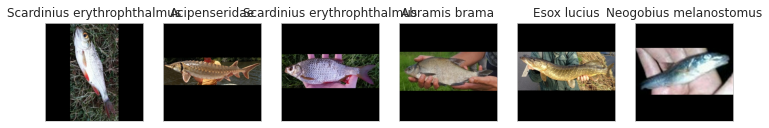

In [58]:
fig = plt.figure(figsize=(25,10))
for i in range(6):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    image_test = decode_image_from_file(df_test_dataset['img_path'].values[i])
    plt.imshow(image_test)
    pred = label_name[pd.DataFrame(model.predict(decode_image_from_file(df_test_dataset['img_path'].values[i])[None,:])).idxmax(axis=1)[0]]
    #plt.title(label_name[y_train[i][0]] + ' ({})'.format(label_name[pd.DataFrame(pred_train).idxmax(axis=1)[i]]))
    plt.title('{}'.format(pred))

In [59]:
def get_label(x):
    return label_name[x[0]]

df_pred_ans = pd.DataFrame(data={'pred_ans': model.predict(test_dataset).argmax(axis=1)})['pred_ans'].map(label_name)
df_pred_ans

0       Scardinius erythrophthalmus
1                     Acipenseridae
2       Scardinius erythrophthalmus
3                     Abramis brama
4                       Esox lucius
                   ...             
2239                Blicca bjoerkna
2240                Blicca bjoerkna
2241            Carassius carassius
2242                 Silurus glanis
2243                  Barbus barbus
Name: pred_ans, Length: 2244, dtype: object

In [60]:
df_true_ans = df_test_dataset['ans']
df_true_ans

0       Scardinius erythrophthalmus
1                     Acipenseridae
2       Scardinius erythrophthalmus
3                     Abramis brama
4                       Esox lucius
                   ...             
2239                Blicca bjoerkna
2240                Blicca bjoerkna
2241            Carassius carassius
2242                 Silurus glanis
2243                  Barbus barbus
Name: ans, Length: 2244, dtype: object

In [61]:
matrix = metrics.confusion_matrix(df_true_ans, df_pred_ans, labels=list(label_name.values()))
matrix_norm = metrics.confusion_matrix(df_true_ans, df_pred_ans, labels=list(label_name.values()), normalize='true').round(1)

In [62]:
plot_color_gradients = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                        'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                        'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

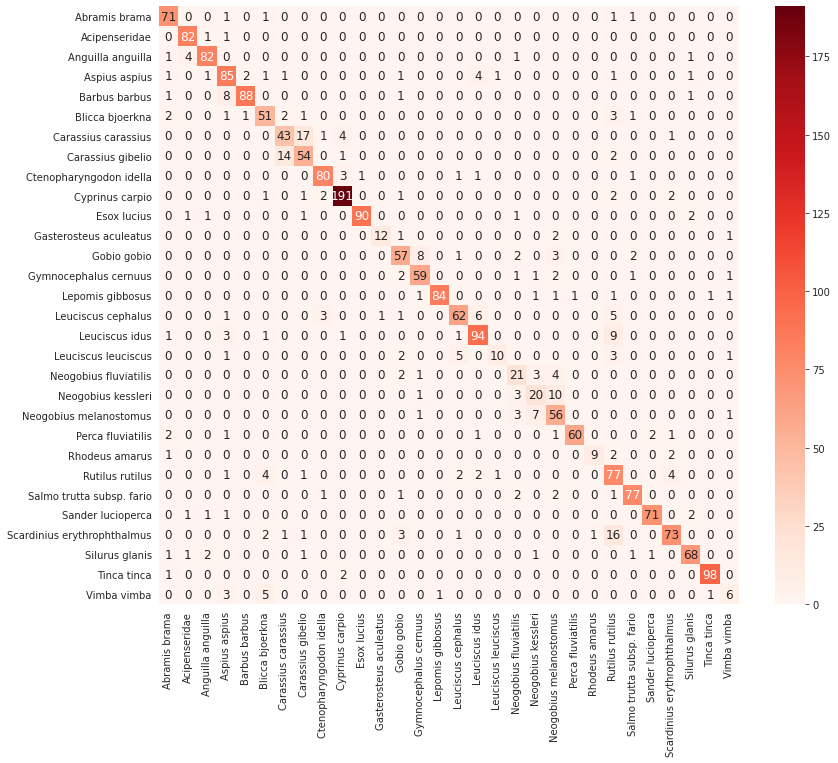

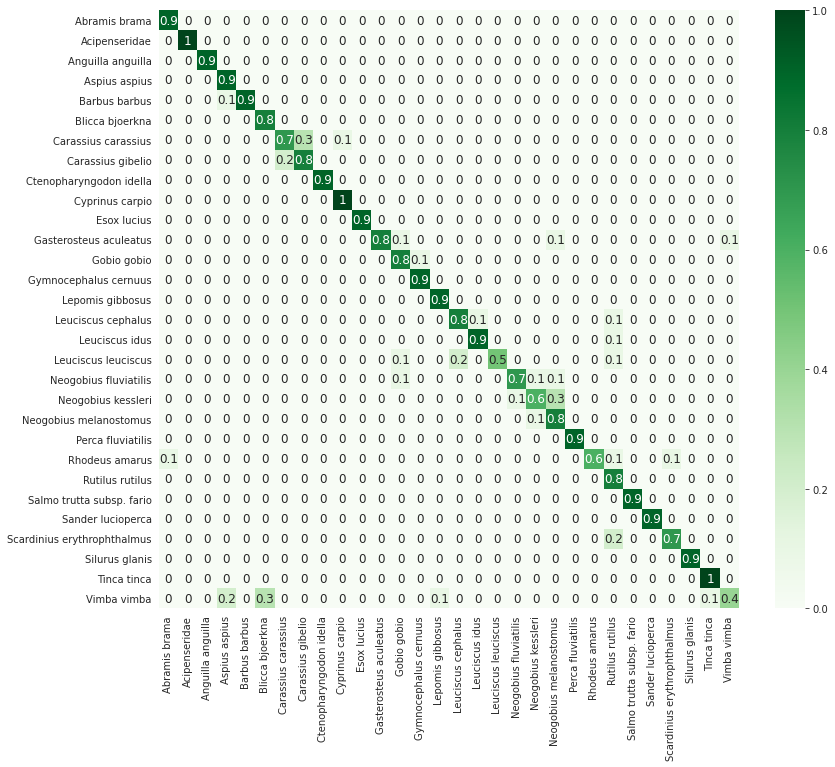

In [63]:
plt.figure(figsize=(13,11))
cm1= pd.DataFrame(matrix, columns=targets, index=targets)
cm1_norm= pd.DataFrame(matrix_norm, columns=targets, index=targets)

# display((cm1/cm1.sum(axis=0)*100).style.background_gradient(axis=0))
#for schem in plot_color_gradients:
#sns.set(font_scale=1.0) # for label size
sns.heatmap(cm1, annot=True, annot_kws={"size": 12}, fmt="d", cmap=plot_color_gradients[5])
plt.show()
plt.figure(figsize=(13,11))
sns.heatmap(cm1_norm, annot=True, annot_kws={"size": 12}, cmap=plot_color_gradients[3])
plt.show()

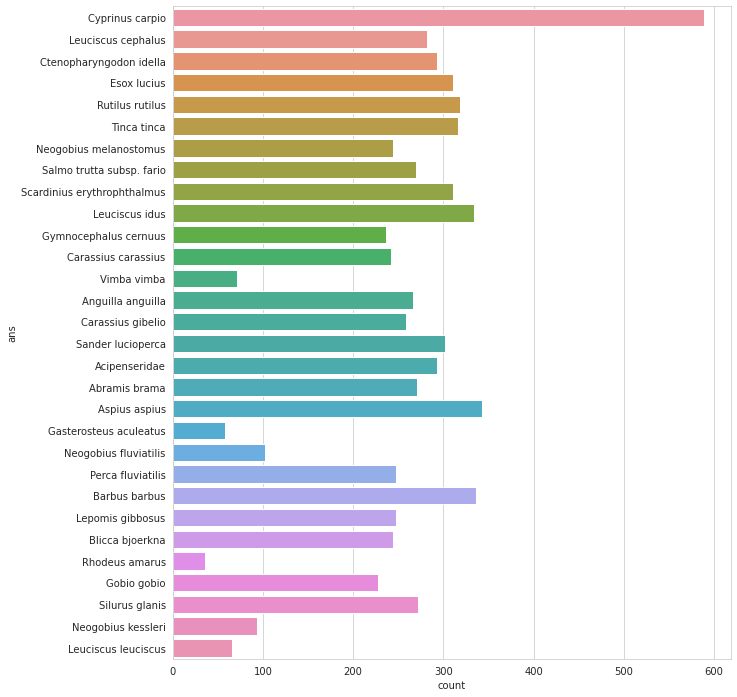

In [64]:
plt.figure(figsize=(10,12))
sns.countplot(data = df_train_dataset, y = 'ans')
plt.show()